In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import os

# 设置随机种子以确保结果可复现
torch.manual_seed(42)
np.random.seed(42)

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ===========================================
# 问题设置
# ===========================================
# 定义域: [0,2]×[0,1]×[0,0.5] (x,y,t)
x_min, x_max = 0.0, 2.0
y_min, y_max = 0.0, 1.0
t_start, t_end = 0.0, 0.5

# 扩散系数张量 K (2x2矩阵)
K = torch.tensor([[1.0, 0.0],
                  [0.0, 1.0]], dtype=torch.float32).to(device)

# 源项 f=0
f = 0.0

# 精确解 (用于验证)
def exact_solution(x, y, t):
    return np.exp(x + y + t)

# ===========================================
# PINN 模型
# ===========================================
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        
        # 构建全连接网络
        self.linears = nn.ModuleList()
        for i in range(len(layers)-1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
            
        # 初始化权重
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).to(device)
        
        a = x
        for i, linear in enumerate(self.linears[:-1]):
            z = linear(a)
            a = self.activation(z)
        
        a = self.linears[-1](a)
        return a

# ===========================================
# VPINN 模型
# ===========================================
class VPINN(nn.Module):
    def __init__(self, layers):
        super(VPINN, self).__init__()
        self.activation = nn.Tanh()
        
        # 构建全连接网络
        self.linears = nn.ModuleList()
        for i in range(len(layers)-1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
            
        # 初始化权重
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32).to(device)
        
        a = x
        for i, linear in enumerate(self.linears[:-1]):
            z = linear(a)
            a = self.activation(z)
        
        a = self.linears[-1](a)
        return a

# ===========================================
# 损失函数 (无源项)
# ===========================================
def pinn_loss(model, x, y, t, K):
    """计算PINN的损失函数 (无源项)"""
    # 启用梯度计算
    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True
    
    # 组合输入
    coords = torch.stack([x, y, t], dim=1)
    
    # 模型预测
    u = model(coords)
    
    # 检查模型输出
    if torch.isnan(u).any() or torch.isinf(u).any():
        print("Warning: Model output contains NaN or Inf!")
        # 返回一个较大的损失值，但避免nan
        return torch.tensor(1e6, device=device), torch.tensor(1e6, device=device), torch.tensor(1e6, device=device)
    
    # 计算梯度
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), 
                             create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), 
                             create_graph=True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), 
                             create_graph=True, retain_graph=True)[0]
    
    # 计算二阶导数
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), 
                              create_graph=True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), 
                              create_graph=True, retain_graph=True)[0]
    
    # PDE残差: ∂u/∂t - ∇·(K∇u) (无源项)
    residual = u_t - (K[0,0]*u_xx + K[1,1]*u_yy)
    
    # 边界条件损失
    tol = 1e-5
    boundary_mask = (
        (torch.abs(x - x_min) < tol) | 
        (torch.abs(x - x_max) < tol) | 
        (torch.abs(y - y_min) < tol) | 
        (torch.abs(y - y_max) < tol) | 
        (torch.abs(t - t_start) < tol)
    )
    
    # 确保有边界点
    if boundary_mask.sum() > 0:
        u_boundary = u[boundary_mask]
        # 向量化计算精确解
        x_boundary = x[boundary_mask]
        y_boundary = y[boundary_mask]
        t_boundary = t[boundary_mask]
        exact_boundary = torch.exp(x_boundary + y_boundary + t_boundary)
        bc_loss = torch.mean((u_boundary - exact_boundary)**2)
    else:
        bc_loss = torch.tensor(0.0).to(device)
    
    # 计算损失
    pde_loss = torch.mean(residual**2)
    
    # 总损失
    total_loss = pde_loss + bc_loss
    
    return total_loss, pde_loss, bc_loss

def vpinn_loss(model, x, y, t, K):
    """计算VPINN的损失函数（变分形式，无源项）"""
    # 启用梯度计算
    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True
    
    # 组合输入
    coords = torch.stack([x, y, t], dim=1)
    
    # 模型预测
    u = model(coords)
    
    # 计算梯度
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), 
                             create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), 
                             create_graph=True, retain_graph=True)[0]
    
    # 变分形式: ∫(∂u/∂t·v + K∇u·∇v) dΩ (无源项)
    # 这里我们使用模型预测作为测试函数v
    v = u.detach()  # 测试函数不参与梯度计算
    
    # 计算时间导数
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), 
                            create_graph=True, retain_graph=True)[0]
    
    # 计算变分残差
    integrand = (u_t * v.detach() + 
                K[0,0]*u_x*v.detach() + 
                K[1,1]*u_y*v.detach())
    
    # 使用蒙特卡洛积分近似域积分
    domain_integral = torch.mean(integrand)
    
    # 边界条件损失
    boundary_mask = (
        (x == x_min) | (x == x_max) | 
        (y == y_min) | (y == y_max) | 
        (t == t_start)
    )
    
    u_boundary = u[boundary_mask]
    
    # 计算边界上的精确解
    exact_boundary = torch.zeros_like(u_boundary)
    for i, (xi, yi, ti) in enumerate(zip(x[boundary_mask], y[boundary_mask], t[boundary_mask])):
        exact_boundary[i] = exact_solution(xi.item(), yi.item(), ti.item())
    
    bc_loss = torch.mean((u_boundary - exact_boundary)**2)
    
    # 总损失
    total_loss = domain_integral**2 + bc_loss
    
    return total_loss, domain_integral**2, bc_loss

Using device: cuda


In [13]:
# ===========================================
# 训练函数
# ===========================================
def train_pinn(epochs=5000, lr=0.001, n_points=1000):
    """训练PINN模型"""
    print("Training PINN model...")
    
    # 创建模型
    model = PINN([3, 20, 20, 20, 1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # 记录损失
    total_losses = []
    pde_losses = []
    bc_losses = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # 生成训练数据
        x = torch.FloatTensor(n_points).uniform_(x_min, x_max).to(device)
        y = torch.FloatTensor(n_points).uniform_(y_min, y_max).to(device)
        t = torch.FloatTensor(n_points).uniform_(t_start, t_end).to(device)
        
        # 计算损失
        optimizer.zero_grad()
        total_loss, pde_loss, bc_loss = pinn_loss(model, x, y, t, K)
        
        # 反向传播
        total_loss.backward()
        optimizer.step()
        
        # 记录损失
        total_losses.append(total_loss.item())
        pde_losses.append(pde_loss.item())
        bc_losses.append(bc_loss.item())
        
        # 打印进度
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} - Total Loss: {total_loss.item():.6f}, "
                  f"PDE Loss: {pde_loss.item():.6f}, BC Loss: {bc_loss.item():.6f}")
    
    training_time = time.time() - start_time
    print(f"PINN training completed in {training_time:.2f} seconds")
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(total_losses, label='Total Loss')
    plt.plot(pde_losses, label='PDE Loss')
    plt.plot(bc_losses, label='BC Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('PINN Training Loss (No Source)')
    plt.legend()
    plt.grid(True)
    plt.savefig('pinn_loss_curve_no_source.png')
    plt.show()
    
    return model

def train_vpinn(epochs=2000, lr=0.001, n_points=1000):
    """训练VPINN模型"""
    print("Training VPINN model...")
    
    # 创建模型
    model = VPINN([3, 20, 20, 20, 1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # 记录损失
    total_losses = []
    pde_losses = []
    bc_losses = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # 生成训练数据
        x = torch.FloatTensor(n_points).uniform_(x_min, x_max).to(device)
        y = torch.FloatTensor(n_points).uniform_(y_min, y_max).to(device)
        t = torch.FloatTensor(n_points).uniform_(t_start, t_end).to(device)
        
        # 计算损失
        optimizer.zero_grad()
        total_loss, pde_loss, bc_loss = vpinn_loss(model, x, y, t, K)
        
        # 反向传播
        total_loss.backward()
        optimizer.step()
        
        # 记录损失
        total_losses.append(total_loss.item())
        pde_losses.append(pde_loss.item())
        bc_losses.append(bc_loss.item())
        
        # 打印进度
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} - Total Loss: {total_loss.item():.6f}, "
                  f"PDE Loss: {pde_loss.item():.6f}, BC Loss: {bc_loss.item():.6f}")
    
    training_time = time.time() - start_time
    print(f"VPINN training completed in {training_time:.2f} seconds")
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(total_losses, label='Total Loss')
    plt.plot(pde_losses, label='PDE Loss')
    plt.plot(bc_losses, label='BC Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('VPINN Training Loss (No Source)')
    plt.legend()
    plt.grid(True)
    plt.savefig('vpinn_loss_curve_no_source.png')
    plt.show()
    
    return model



Training PINN model...
Epoch 0/5000 - Total Loss: 0.027389, PDE Loss: 0.027389, BC Loss: 0.000000
Epoch 100/5000 - Total Loss: 0.027833, PDE Loss: 0.027833, BC Loss: 0.000000
Epoch 200/5000 - Total Loss: 0.043624, PDE Loss: 0.043624, BC Loss: 0.000000
Epoch 300/5000 - Total Loss: 0.017386, PDE Loss: 0.017386, BC Loss: 0.000000
Epoch 400/5000 - Total Loss: 0.026646, PDE Loss: 0.026646, BC Loss: 0.000000
Epoch 500/5000 - Total Loss: 0.016926, PDE Loss: 0.016926, BC Loss: 0.000000
Epoch 600/5000 - Total Loss: 0.013044, PDE Loss: 0.013044, BC Loss: 0.000000
Epoch 700/5000 - Total Loss: 0.014013, PDE Loss: 0.014013, BC Loss: 0.000000
Epoch 800/5000 - Total Loss: 0.010857, PDE Loss: 0.010857, BC Loss: 0.000000
Epoch 900/5000 - Total Loss: 0.019876, PDE Loss: 0.019876, BC Loss: 0.000000
Epoch 1000/5000 - Total Loss: 1.916103, PDE Loss: 0.023066, BC Loss: 1.893037
Epoch 1100/5000 - Total Loss: 0.006950, PDE Loss: 0.006950, BC Loss: 0.000000
Epoch 1200/5000 - Total Loss: 0.008106, PDE Loss: 0.

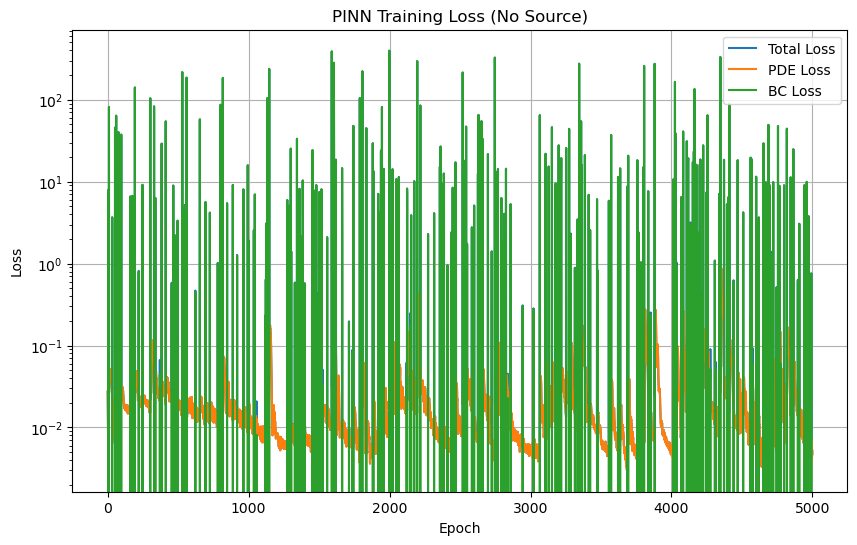


Training VPINN model...
Epoch 0/2000 - Total Loss: nan, PDE Loss: 0.086900, BC Loss: nan
Epoch 100/2000 - Total Loss: nan, PDE Loss: 0.000194, BC Loss: nan
Epoch 200/2000 - Total Loss: nan, PDE Loss: 0.000079, BC Loss: nan
Epoch 300/2000 - Total Loss: nan, PDE Loss: 0.000015, BC Loss: nan
Epoch 400/2000 - Total Loss: nan, PDE Loss: 0.000014, BC Loss: nan
Epoch 500/2000 - Total Loss: nan, PDE Loss: 0.000004, BC Loss: nan
Epoch 600/2000 - Total Loss: nan, PDE Loss: 0.000000, BC Loss: nan
Epoch 700/2000 - Total Loss: nan, PDE Loss: 0.000004, BC Loss: nan
Epoch 800/2000 - Total Loss: nan, PDE Loss: 0.000000, BC Loss: nan
Epoch 900/2000 - Total Loss: nan, PDE Loss: 0.000003, BC Loss: nan
Epoch 1000/2000 - Total Loss: nan, PDE Loss: 0.000005, BC Loss: nan
Epoch 1100/2000 - Total Loss: nan, PDE Loss: 0.000018, BC Loss: nan
Epoch 1200/2000 - Total Loss: nan, PDE Loss: 0.000408, BC Loss: nan
Epoch 1300/2000 - Total Loss: nan, PDE Loss: 0.000000, BC Loss: nan
Epoch 1400/2000 - Total Loss: nan, 

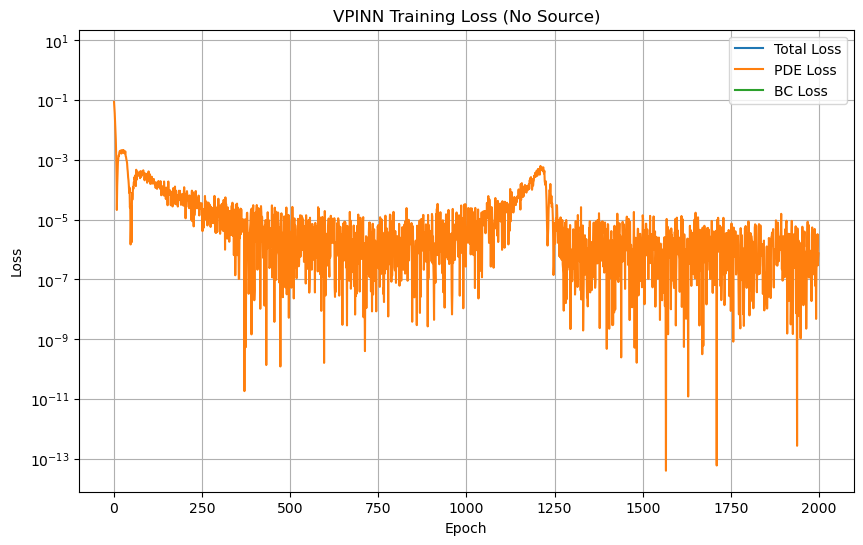

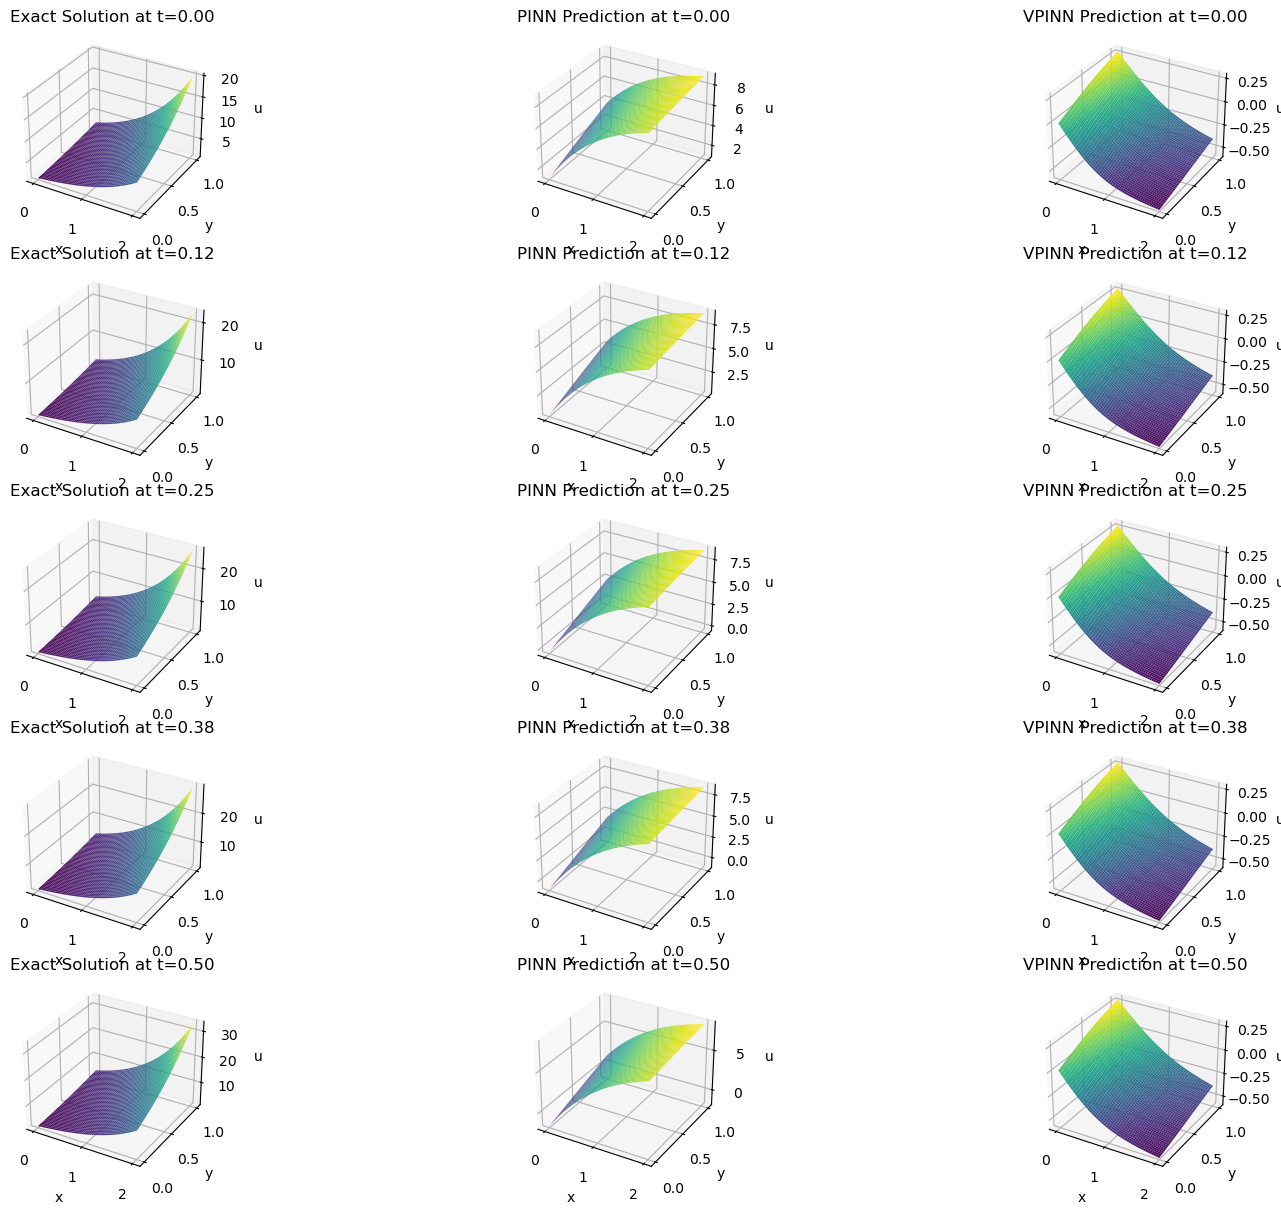

Models saved to pinn_model_nonstationary_no_source.pth and vpinn_model_nonstationary_no_source.pth


: 

In [ ]:
# ===========================================
# 训练和可视化
# ===========================================
if __name__ == "__main__":
    # 训练 PINN
    print("\n" + "="*50)
    pinn_model = train_pinn(epochs=5000)
    
    # 训练 VPINN
    print("\n" + "="*50)
    vpinn_model = train_vpinn(epochs=2000)
    
    # 可视化结果
    x = np.linspace(x_min, x_max, 50)
    y = np.linspace(y_min, y_max, 50)
    t_values = np.linspace(t_start, t_end, 5)  # 选择几个时间点可视化
    
    fig = plt.figure(figsize=(18, 12))
    
    for idx, t_val in enumerate(t_values):
        # 创建网格
        X, Y = np.meshgrid(x, y)
        xy = np.vstack([X.ravel(), Y.ravel()]).T
        t_array = np.full((xy.shape[0], 1), t_val)
        xyt = np.hstack([xy, t_array])
        
        # 精确解
        exact = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                exact[i, j] = exact_solution(X[i, j], Y[i, j], t_val)
        
        # PINN 预测
        with torch.no_grad():
            xyt_t = torch.tensor(xyt, dtype=torch.float32).to(device)
            pinn_pred = pinn_model(xyt_t).cpu().numpy().reshape(X.shape)
        
        # VPINN 预测
        with torch.no_grad():
            xyt_t = torch.tensor(xyt, dtype=torch.float32).to(device)
            vpinn_pred = vpinn_model(xyt_t).cpu().numpy().reshape(X.shape)
        
        # 计算误差
        pinn_error = np.abs(pinn_pred - exact)
        vpinn_error = np.abs(vpinn_pred - exact)
        
        # 绘图 - 精确解
        ax1 = fig.add_subplot(5, 3, idx*3 + 1, projection='3d')
        ax1.plot_surface(X, Y, exact, cmap='viridis')
        ax1.set_title(f'Exact Solution at t={t_val:.2f}')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_zlabel('u')
        
        # 绘图 - PINN 预测
        ax2 = fig.add_subplot(5, 3, idx*3 + 2, projection='3d')
        ax2.plot_surface(X, Y, pinn_pred, cmap='viridis')
        ax2.set_title(f'PINN Prediction at t={t_val:.2f}')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_zlabel('u')
        
        # 绘图 - VPINN 预测
        ax3 = fig.add_subplot(5, 3, idx*3 + 3, projection='3d')
        ax3.plot_surface(X, Y, vpinn_pred, cmap='viridis')
        ax3.set_title(f'VPINN Prediction at t={t_val:.2f}')
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')
        ax3.set_zlabel('u')
    
    plt.tight_layout()
    plt.savefig('pinn_vpinn_comparison_nonstationary_no_source.png')
    plt.show()
    
    # 保存模型
    torch.save(pinn_model.state_dict(), 'pinn_model_nonstationary_no_source_PARA.pth')
    torch.save(vpinn_model.state_dict(), 'vpinn_model_nonstationary_no_source_PARA.pth')
    print("Models saved to pinn_model_nonstationary_no_source.pth and vpinn_model_nonstationary_no_source.pth")